In [1]:
# Cell for module imports
import pandas as pd                          # for working with a dataframe
import nltk                                  # text preprocessing steps
import re                                    # for customized text preprocessing
import string                                # for customized text preprocessing
from nltk.corpus import stopwords            # stopword removal
from nltk.tokenize import word_tokenize      # tokenization
from nltk.stem import WordNetLemmatizer      # lemmatization


from sklearn.model_selection import train_test_split   # split to train/test
from sklearn.feature_extraction.text import TfidfVectorizer # vectorizer

from keras.preprocessing.text import Tokenizer  # LSTM tokenization
from keras.preprocessing.sequence import pad_sequences  # LSTM padding

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder     # onehot encoding for LSTM

from sklearn.svm import LinearSVC                # SVM model

from sklearn.metrics import accuracy_score      # for SVM evaluation


# LSTM model structuring
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [2]:
# Additional libraries for NLTK preprocessing
nltk.download('punkt')
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load the dataset
df = pd.read_csv('file.csv', header = 0, index_col = 0)

In [4]:
# Display the contents
df.head()

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [5]:
# Set up a text preprocessing customized function

def text_preprocessing(text):
  # lowercasing
  text = text.lower()

  # getting rid of whitespaces
  text = " ".join(text.split())

  # # removing numbers
  text = re.sub(r'\d+', '', text)

  # remove URLs
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  text = url_pattern.sub(" ", text)

  # remove punctuation
  text = "".join([char for char in text if char not in string.punctuation])

  # remove special characters
  text = ''.join(l for l in text if l.isalnum() or l.isspace())

  # tokenize
  tokenized = word_tokenize(text)

  # remove stopwords
  stop_words = set(stopwords.words('english'))
  tokenized = [word for word in tokenized if word not in stop_words]

  # lemmatization
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokenized]
  result = ' '.join(lemmatized_tokens)

  return result

In [6]:
# Apply text_preprocessing to our tweets column
df['tweets'] = df['tweets'].apply(text_preprocessing)

In [7]:
# Ensuring all required changes have been applied
df.head(10)

,tweets,labels
0,chatgpt optimizing language model dialogue openai,neutral
1,try talking chatgpt new ai system optimized di...,good
2,chatgpt optimizing language model dialogue ai ...,neutral
3,thrilled share chatgpt new model optimized dia...,good
4,minute ago openai released new chatgpt nnand u...,bad
5,launched chatgpt new ai system optimized dialogue,good
6,minute ago openai released new chatgpt nnand u...,bad
7,chatgpt coming strong refusing help stalk some...,good
8,penal deployed thing ive helping build last co...,good
9,research preview newest model chatgptnnwere tr...,neutral


In [8]:
# For labels column, encode to numeric
df['labels'] = df['labels'].apply(lambda x: 1 if x == "good" else (-1 if x == "bad" else 0))

In [9]:
# Confirm output
df.head()

,tweets,labels
0,chatgpt optimizing language model dialogue openai,0
1,try talking chatgpt new ai system optimized di...,1
2,chatgpt optimizing language model dialogue ai ...,0
3,thrilled share chatgpt new model optimized dia...,1
4,minute ago openai released new chatgpt nnand u...,-1


In [10]:
# Split into train and test data
text = df['tweets'].values
labels = df['labels'].values
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.3)

In [11]:
# Instantiate a vectorizer and convert to num vectors
vectorizer = TfidfVectorizer(analyzer='word')
features_train = vectorizer.fit_transform(X_train)
features_test = vectorizer.transform(X_test)

In [12]:
# SVM MODEL
svm = LinearSVC()
svm.fit(features_train, y_train)

# Prediction and accuracy
predictions = svm.predict(features_test)
accuracy = accuracy_score(y_test, predictions)
round(accuracy, 2)

0.82

<Axes: xlabel='label', ylabel='count'>

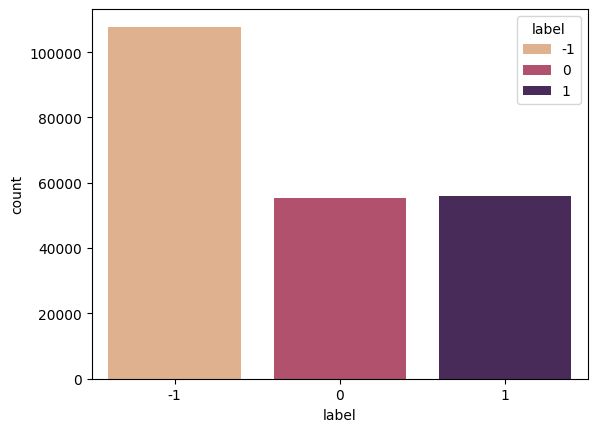

In [13]:
# Check whether classes are balanced to determine best evaluation metrics
import seaborn as sns
determine_balance = df['labels'].value_counts().reset_index()
determine_balance.columns = ['label', 'count']
sns.barplot(x = "label", y = "count", hue = "label", data = determine_balance, palette = "flare")

# Note class imbalance in the dataset - negative sentiment prevails by half!

In [17]:
from sklearn.metrics import confusion_matrix

# Identify TP, TN, FP, FN for each class
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix

array([[30617,  1133,   490],
       [ 4010,  9361,  3413],
       [  563,  2076, 14126]])

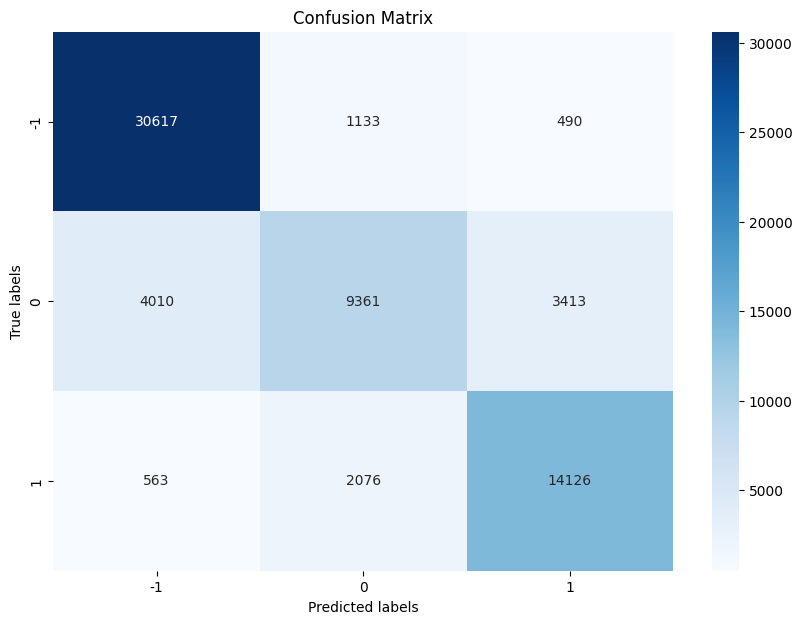

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

labelling = [-1, 0, 1]
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels = labelling, yticklabels = labelling)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, predictions, average = "weighted")  # accounts for label imbalance, results are slightly higher than with simple macro

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

# Note stable performance across all metrics!

precision: 0.8309659156690343
recall: 0.8338476037027467
fscore: 0.8252745268671361


In [16]:
# LSTM MODEL

# Label encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoded = to_categorical(integer_encoded)

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tweets'])
sequences = tokenizer.texts_to_sequences(df['tweets'])

# Padding
max_sequence_length = max([len(seq) for seq in sequences])
data = pad_sequences(sequences, maxlen=max_sequence_length)

In [18]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, onehot_encoded, test_size=0.3)

In [19]:
# Determine input dimensions
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim=150))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

284179


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 150)         42626850  
                                                                 
 spatial_dropout1d (Spatial  (None, None, 150)         0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 42770085 (163.15 MB)
Trainable params: 42770085 (163.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# Train the LSTM model
history = model.fit(X_train, y_train, epochs=5, batch_size=64)

Epoch 1/5
2399/2399 [==============================] - 3285s 1s/step - loss: 0.2700 - accuracy: 0.9033
Epoch 2/5
2399/2399 [==============================] - 3252s 1s/step - loss: 0.1114 - accuracy: 0.9604
Epoch 3/5
2399/2399 [==============================] - 3331s 1s/step - loss: 0.0570 - accuracy: 0.9800
Epoch 4/5
2399/2399 [==============================] - 3460s 1s/step - loss: 0.0401 - accuracy: 0.9858
Epoch 5/5
2399/2399 [==============================] - 3387s 1s/step - loss: 0.0301 - accuracy: 0.9895


In [24]:
model.evaluate(X_test, y_test)

2056/2056 [==============================] - 78s 38ms/step - loss: 0.3108 - accuracy: 0.9101


[0.3108484447002411, 0.910121738910675]

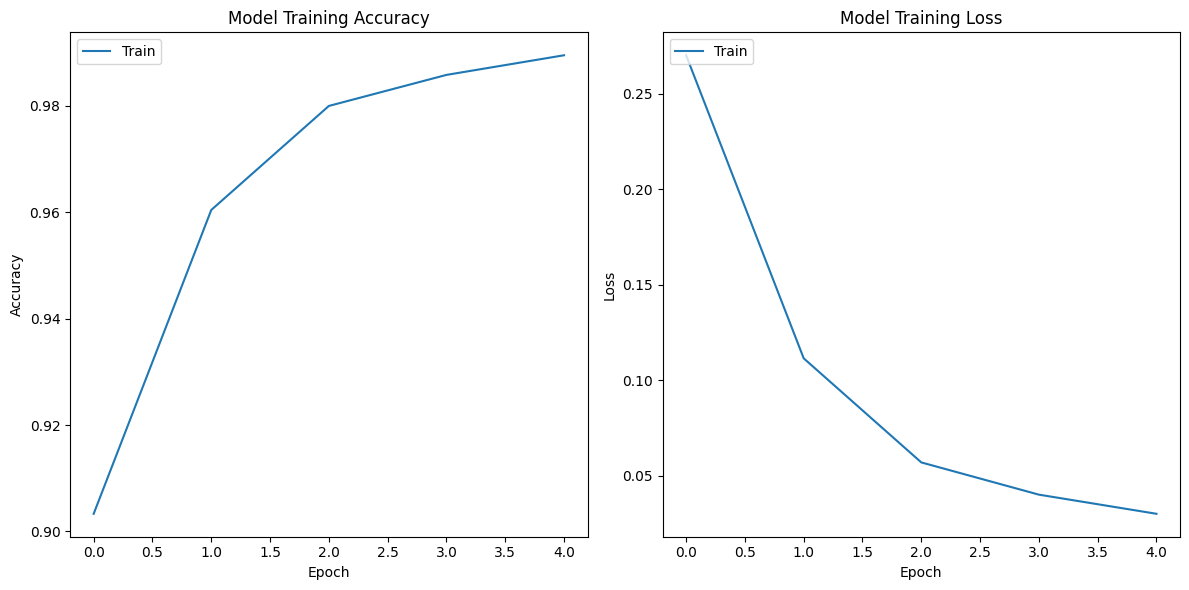

In [23]:
# Plot training accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()

In [25]:
import numpy as np

# Make sure labels are converted back from numeric encoding
prob_pred = model.predict(X_test)
lstm_predictions = np.argmax(prob_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

precision, recall, fscore, support = score(y_test_labels, lstm_predictions, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {fscore}')


2056/2056 [==============================] - 103s 50ms/step
Precision: 0.9120263620652137
Recall: 0.9101217528766207
F1 Score: 0.9108563868013593


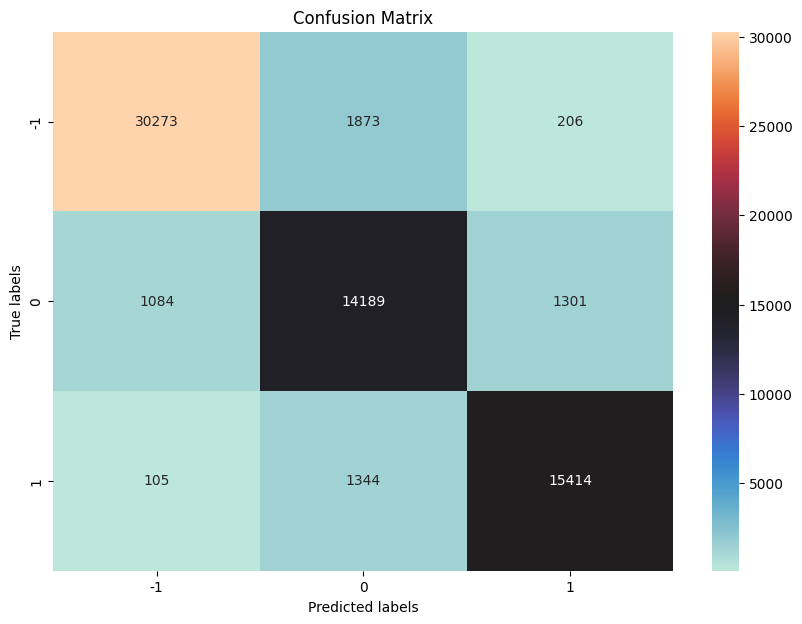

In [29]:
# Confusion matrix

lstm_conf_matrix = confusion_matrix(y_test_labels, lstm_predictions)

plt.figure(figsize=(10,7))
sns.heatmap(lstm_conf_matrix, annot=True, fmt='g', cmap='icefire', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [40]:
# Load our second dataset
# For the purpose of our project, we are selecting only tweet messages

df_2 = pd.read_csv('Twitter Jan Mar.csv')
df_2 = df_2[['content']]

In [41]:
df_2.head()

,content
0,"Free AI marketing and automation tools, strate..."
1,@MecoleHardman4 Chat GPT says it’s 15. 😂
2,https://t.co/FjJSprt0te - Chat with any PDF!\n...
3,"AI muses: ""In the court of life, we must all f..."
4,Most people haven't heard of Chat GPT yet.\nFi...


In [46]:
# Since our dataset is too large, let's select 500 rows at a random

df_2 = df_2.sample(n=500, random_state=42)

In [47]:
# Apply text preprocessing
df_2['content'] = df_2['content'].astype(str)   # tackle float attr error
df_2['content'] = df_2['content'].apply(text_preprocessing)

In [48]:
# Confirm preprocessing completion
df_2.head()

,content
136396,published chatgptnet library allows easily int...
387384,make money chat gpt follow exact step thread
44226,lack safeguard freedom speech defamation law i...
362089,chatgpt threat opportunity educator teacher ad...
382358,back people thought lock forever amp started s...


In [49]:
# SVM Model Prediction
predictions_svm_df2 = svm.predict(vectorizer.transform(df_2['content']))

In [52]:
# Add as a column to df_2
df_2['svm_predictions'] = predictions_svm_df2

In [53]:
df_2.head()

,content,svm_predictions
136396,published chatgptnet library allows easily int...,1
387384,make money chat gpt follow exact step thread,-1
44226,lack safeguard freedom speech defamation law i...,1
362089,chatgpt threat opportunity educator teacher ad...,0
382358,back people thought lock forever amp started s...,-1


In [55]:
# Tokenization
tokenizer.fit_on_texts(df_2['content'])
sequences = tokenizer.texts_to_sequences(df_2['content'])

# Padding
max_sequence_length = max([len(seq) for seq in sequences])
data_2 = pad_sequences(sequences, maxlen=max_sequence_length)

In [56]:
# LSTM prediction
predictions_lstm_df2 = model.predict(data_2)

16/16 [==============================] - 1s 36ms/step


In [64]:
# Make sure predictions are mapped in accordance with uniform labelling
label_mapping = [-1, 0, 1]
predicted_classes_lstm = np.argmax(predictions_lstm_df2, axis=1)
predicted_classes_mapped = np.array(label_mapping)[predicted_classes_lstm]


In [65]:
df_2['lstm_predictions'] = predicted_classes_mapped


In [66]:
df_2.head()

,content,svm_predictions,lstm_predictions
136396,published chatgptnet library allows easily int...,1,1
387384,make money chat gpt follow exact step thread,-1,-1
44226,lack safeguard freedom speech defamation law i...,1,-1
362089,chatgpt threat opportunity educator teacher ad...,0,-1
382358,back people thought lock forever amp started s...,-1,-1


In [68]:
# Write results to CSV for further analysis
df_2.to_csv('test_result.csv', index=False)